In [1]:
import numpy as np

from squlearn import Executor
from squlearn.encoding_circuit import *
from squlearn.kernel import FidelityKernel

Testing duplicates

In [37]:
executor = Executor("pennylane")

n_dim = 3

circuit1 = LayeredEncodingCircuit(n_dim, n_dim)
circuit1.Ry("p")
circuit1.Rx("x")

fqk_expectation_none = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=True, evaluate_duplicates="none")
fqk_pennylane = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=False, evaluate_duplicates="none")
fqk_expectation_duplicates = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=True, evaluate_duplicates="all")


n_dim = 3

np.random.seed(42)
#x_space = np.random.rand(N_samples_x, n_dim)

# fqk_expectation_none.evaluate(x_space, y_space)
# fqk_expectation_duplicates.evaluate(x_space, y_space)
# fqk_pennylane.evaluate(x_space, y_space)

import time
import matplotlib.pyplot as plt

# Define the range of sample sizes to test
sample_sizes = np.logspace(0.7, 3, num=14, dtype=int)

# Initialize lists to store the evaluation times
times_expectation_none = []
times_expectation_duplicates = []
times_pennylane = []

# Measure the evaluation time for each sample size
for size in sample_sizes:
    x_sample = np.random.rand(size, n_dim)
    y_sample = x_sample

    start_time = time.time()
    fqk_expectation_none.evaluate(x_sample, y_sample)
    times_expectation_none.append(time.time() - start_time)

    start_time = time.time()
    fqk_expectation_duplicates.evaluate(x_sample, y_sample)
    times_expectation_duplicates.append(time.time() - start_time)

    start_time = time.time()
    fqk_pennylane.evaluate(x_sample, y_sample)
    times_pennylane.append(time.time() - start_time)



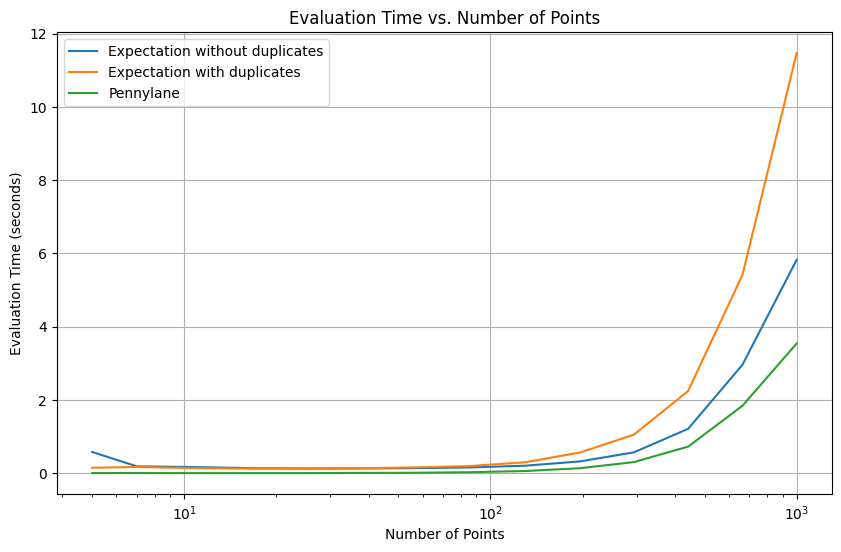

In [36]:

# Plot the evaluation times
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, times_expectation_none, label='Expectation without duplicates')
plt.plot(sample_sizes, times_expectation_duplicates, label='Expectation with duplicates')
plt.plot(sample_sizes, times_pennylane, label='Pennylane')
plt.xlabel('Number of Points')
plt.ylabel('Evaluation Time (seconds)')


#plt.yscale('log')
plt.xscale('log')
plt.title('Evaluation Time vs. Number of Points')
plt.legend()
plt.grid(True)
plt.show()


Normal squlearn K == LowQNN implementation K =  True


## Testing single variable

In [2]:
executor = Executor("pennylane")

N_samples_x = 7
N_samples_y = 4
n_dim = 1

np.random.seed(42)
x_space = np.random.rand(N_samples_x, n_dim)
y_space = x_space #np.random.rand(N_samples_y, n_dim)

circuit1 = LayeredEncodingCircuit(1, 1)
circuit1.Ry("p")
circuit1.Rx("x")

fqk = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=True, evaluate_duplicates="all")

p1 = 0.35
fqk.assign_parameters([p1])


def manual_separable_rx_kernel(x, y, p0):
    # RxRy rotation
    # 0.375*(1 - cos(p0))**2*cos(x0 - y0) + 0.125*(1 - cos(p0))**2*cos(x0 + y0) - 0.5*(1 - cos(p0))**2 - 1.0*cos(p0) - 0.3125*cos(x0 - y0) - 0.1875*cos(x0 + y0) - 0.03125*cos(-2*p0 + x0 + y0) + 0.125*cos(-p0 + x0 + y0) + 0.375*cos(p0 - x0 + y0) + 0.375*cos(p0 + x0 - y0) + 0.125*cos(p0 + x0 + y0) + 0.03125*cos(2*p0 - x0 + y0) + 0.03125*cos(2*p0 + x0 - y0) - 0.03125*cos(2*p0 + x0 + y0) + 1.5

    return (
        0.375 * (1 - np.cos(p0)) ** 2 * np.cos(x - y)
        + 0.125 * (1 - np.cos(p0)) ** 2 * np.cos(x + y)
        - 0.5 * (1 - np.cos(p0)) ** 2
        - 1.0 * np.cos(p0)
        - 0.3125 * np.cos(x - y)
        - 0.1875 * np.cos(x + y)
        - 0.03125 * np.cos(-2 * p0 + x + y)
        + 0.125 * np.cos(-p0 + x + y)
        + 0.375 * np.cos(p0 - x + y)
        + 0.375 * np.cos(p0 + x - y)
        + 0.125 * np.cos(p0 + x + y)
        + 0.03125 * np.cos(2 * p0 - x + y)
        + 0.03125 * np.cos(2 * p0 + x - y)
        - 0.03125 * np.cos(2 * p0 + x + y)
        + 1.5
    )


def manual_separable_rx_kernel_dKdx(x, y, p0):
    """
    # RxRy rotation
    """
    return -0.25 * np.sin(x - y) + 0.125 * np.sin(2 * p0 - x + y) - 0.125 * np.sin(2 * p0 + x - y)


def manual_separable_rx_kernel_dKdp(x, y, p0):
    return 0.5 * (1 - np.cos(x - y)) * np.sin(2 * p0)


def manual_separable_rx_kernel_dKdy(x, y, p0):
    return 0.25 * np.sin(x - y) - 0.125 * np.sin(2 * p0 - x + y) + 0.125 * np.sin(2 * p0 + x - y)


def manual_separable_rx_kernel_dKdxdy(x, y, p0):
    return (
        0.375 * (1 - np.cos(p0)) ** 2 * np.cos(x - y)
        + 0.125 * (1 - np.cos(p0)) ** 2 * np.cos(x + y)
        - 0.3125 * np.cos(x - y)
        - 0.1875 * np.cos(x + y)
        - 0.03125 * np.cos(-2 * p0 + x + y)
        + 0.125 * np.cos(-p0 + x + y)
        + 0.375 * np.cos(p0 - x + y)
        + 0.375 * np.cos(p0 + x - y)
        + 0.125 * np.cos(p0 + x + y)
        + 0.03125 * np.cos(2 * p0 - x + y)
        + 0.03125 * np.cos(2 * p0 + x - y)
        - 0.03125 * np.cos(2 * p0 + x + y)
    )


def matrix_manual_todo(x_array, y_array, p0, todo):
    todo = {
        "K": manual_separable_rx_kernel,
        "dKdx": manual_separable_rx_kernel_dKdx,
        "dKdp": manual_separable_rx_kernel_dKdp,
        "dKdy": manual_separable_rx_kernel_dKdy,
        "dKdxdy": manual_separable_rx_kernel_dKdxdy,
    }[todo]
    k_matrix = np.zeros((len(x_array), len(y_array)))
    for i, x in enumerate(x_array):
        for j, y in enumerate(y_array):
            k_matrix[i, j] = todo(x[0], y[0], p0)
    return k_matrix



In [4]:

print(
    "Normal squlearn K == LowQNN implementation K = ",
    np.allclose(
        fqk.evaluate(x_space, y_space),
        fqk.evaluate_derivatives(x_space, y_space, values=["K"])["K"],
    ),
)
print(
    "K_analyical = K_qnn_squlearn = ",
    np.allclose(matrix_manual_todo(x_space, y_space, p1, "K"), fqk.evaluate(x_space, y_space)),
)
print(
    "dKdx_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"],
    ),
)
print(
    "dKdp_analyical = dKdp_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdp"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdp"])["dKdp"],
    ),
)
print(
    "dKdy_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"],
    ),
)
print(
    "dKdxdy_analyical = dKdxdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdxdy"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdxdy"])["dKdxdy"],
    ),
)

Normal squlearn K == LowQNN implementation K =  True
K_analyical = K_qnn_squlearn =  True
dKdx_analyical = dKdx_qnn_squlearn =  True
dKdp_analyical = dKdp_qnn_squlearn =  True
dKdy_analyical = dKdy_qnn_squlearn =  True
dKdxdy_analyical = dKdxdy_qnn_squlearn =  True


# Testing multi-dimensional

In [5]:
executor = Executor("pennylane")

N_samples_x = 7
N_samples_y = 3
n_dim = 2

np.random.seed(42)
x_space = np.random.rand(N_samples_x, n_dim)
y_space = np.random.rand(N_samples_y, n_dim)

circuit1 = LayeredEncodingCircuit(n_dim, n_dim)
circuit1.Rx("p")
circuit1.Rx("x")

fqk = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=True)
p1 = 0.45
fqk.assign_parameters([p1, p1])


def manual_separable_rx_kernel(x, y, p0):
    # Rx(x0)Rx(p0) \otimes Rx(x1)Rx(p0)

    return (
        0.25 * np.cos(x[0] - y[0])
        + 0.25 * np.cos(x[1] - y[1])
        + 0.125 * np.cos(x[0] - x[1] - y[0] + y[1])
        + 0.125 * np.cos(x[0] + x[1] - y[0] - y[1])
        + 0.25
    )


def manual_separable_rx_kernel_dKdx1(x, y, p0):
    return -0.25 * (np.cos(x[1] - y[1]) + 1) * np.sin(x[0] - y[0])


def manual_separable_rx_kernel_dKdx2(x, y, p0):
    return -0.25 * (np.cos(x[0] - y[0]) + 1) * np.sin(x[1] - y[1])


def manual_separable_rx_kernel_dKdy1(x, y, p0):
    # 1.0*sin(x0/2 - y0/2)*cos(x0/2 - y0/2)*cos(x1/2 - y1/2)**2
    return (
        1.0
        * np.sin(x[0] / 2 - y[0] / 2)
        * np.cos(x[0] / 2 - y[0] / 2)
        * np.cos(x[1] / 2 - y[1] / 2) ** 2
    )


def manual_separable_rx_kernel_dKdy2(x, y, p0):
    return (
        1.0
        * np.sin(x[1] / 2 - y[1] / 2)
        * np.cos(x[0] / 2 - y[0] / 2) ** 2
        * np.cos(x[1] / 2 - y[1] / 2)
    )


def matrix_manual_todo(x_array, y_array, p0, todo):
    todo = {
        "K": manual_separable_rx_kernel,
        "dKdx1": manual_separable_rx_kernel_dKdx1,
        "dKdx2": manual_separable_rx_kernel_dKdx2,
        "dKdy1": manual_separable_rx_kernel_dKdy1,
        "dKdy2": manual_separable_rx_kernel_dKdy2,
    }[todo]
    k_matrix = np.zeros((len(x_array), len(y_array)))
    for i, x in enumerate(x_array):
        for j, y in enumerate(y_array):
            k_matrix[i, j] = todo(x, y, p0)
    return k_matrix


print(
    "Normal squlearn K == LowQNN implementation K = ",
    np.allclose(
        fqk.evaluate(x_space, y_space),
        fqk.evaluate_derivatives(x_space, y_space, values=["K"])["K"],
    ),
)
print(
    "K_analyical = K_qnn_squlearn = ",
    np.allclose(matrix_manual_todo(x_space, y_space, p1, "K"), fqk.evaluate(x_space, y_space)),
)
print(
    "dKdx1_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx1"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"][0],
    ),
)
print(
    "dKdx2_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx2"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"][1],
    ),
)
print(
    "dKdy1_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy1"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"][0],
    ),
)
print(
    "dKdy2_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy2"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"][1],
    ),
)

Normal squlearn K == LowQNN implementation K =  True
K_analyical = K_qnn_squlearn =  True
dKdx1_analyical = dKdx_qnn_squlearn =  True
dKdx2_analyical = dKdx_qnn_squlearn =  True
dKdy1_analyical = dKdy_qnn_squlearn =  True
dKdy2_analyical = dKdy_qnn_squlearn =  True


In [6]:

circuit1 = LayeredEncodingCircuit(3, 3)
circuit1.Rx("p")
circuit1.Rx("x")

fqk = FidelityKernel(circuit1, executor=executor, caching=False, use_expectation=True, evaluate_duplicates="all")
p1 = 0.45
fqk.assign_parameters([p1, p1, p1])

x_space = np.random.rand(3, 3)
fqk.evaluate_derivatives(x_space, x_space, values="dKdx")

array([[[ 0.00000000e+00, -1.11440708e-01, -1.89027546e-01],
        [ 1.11440708e-01,  0.00000000e+00, -8.21208811e-02],
        [ 1.89027546e-01,  8.21208811e-02, -2.77555756e-17]],

       [[-1.38777878e-17,  1.44193609e-01,  1.71428878e-01],
        [-1.44193609e-01,  2.77555756e-17,  2.85971019e-02],
        [-1.71428878e-01, -2.85971019e-02, -5.55111512e-17]],

       [[-2.77555756e-17,  2.27309807e-01,  1.36779507e-01],
        [-2.27309807e-01,  5.55111512e-17, -9.50407020e-02],
        [-1.36779507e-01,  9.50407020e-02,  0.00000000e+00]]])

In [7]:
import numpy as np
import sympy as sp
from squlearn import Executor
from squlearn.encoding_circuit import LayeredEncodingCircuit
from squlearn.kernel.lowlevel_kernel import FidelityKernel

def setup_single_variable():
    x, y, p = sp.symbols("x y p")
    sympy_K = 0.375 * (1 - sp.cos(p)) ** 2 * sp.cos(x - y) + 0.125 * (1 - sp.cos(p)) ** 2 * sp.cos(x + y) - 0.5 * (1 - sp.cos(p)) ** 2 - 1.0 * sp.cos(p) - 0.3125 * sp.cos(x - y) - 0.1875 * sp.cos(x + y) - 0.03125 * sp.cos(-2 * p + x + y) + 0.125 * sp.cos(-p + x + y) + 0.375 * sp.cos(p - x + y) + 0.375 * sp.cos(p + x - y) + 0.125 * sp.cos(p + x + y) + 0.03125 * sp.cos(2 * p - x + y) + 0.03125 * sp.cos(2 * p + x - y) - 0.03125 * sp.cos(2 * p + x + y) + 1.5

    sympy_values = {
        "K": sympy_K,
        "dKdx": sp.diff(sympy_K, x),
        "dKdy": sp.diff(sympy_K, y),
        "dKdxdx": sp.diff(sp.diff(sympy_K, x), x),
        "dKdp": sp.diff(sympy_K, p),
    }

    return x, y, p, sympy_values

def setup_multi_variable():
    x0, y0, p0 = sp.symbols("x0 y0 p0")
    x1, y1, p1 = sp.symbols("x1 y1 p1")

    sympy_K = 0.25*sp.cos(x0 - y0) + 0.25*sp.cos(x1 - y1) + 0.125*sp.cos(x0 - x1 - y0 + y1) + 0.125*sp.cos(x0 + x1 - y0 - y1) + 0.25
    
    sympy_values = {
        "K": sympy_K,
        "dKdx0": sp.diff(sympy_K, x0),
        "dKdx1": sp.diff(sympy_K, x1),
        "dKdy0": sp.diff(sympy_K, y0),
        "dKdy1": sp.diff(sympy_K, y1),
        "dKdp0": sp.diff(sympy_K, p0),
        "dKdp1": sp.diff(sympy_K, p1),
    }

    return x0, y0, x1, y1, p0, p1, sympy_values

def create_fidelity_kernel(num_features, initial_parameters):
    executor = Executor()
    encoding_circuit = LayeredEncodingCircuit(
        num_qubits=num_features, num_features=num_features
    )

    if num_features == 1:
        encoding_circuit.Ry("p") #For 1 feature, the FQK analytical kernel is:  Rx(x)@Ry(p)
    elif num_features == 2:
        encoding_circuit.Rx("p") #For 2 features, the FQK analytical kernel is:  Rx(x0)@Ry(p0) x Rx(x1)@Ry(p1)
    encoding_circuit.Rx("x")
    
    kernel = FidelityKernel(encoding_circuit, executor=executor, caching=False, use_expectation=True, initial_parameters=initial_parameters)    

    return kernel

def test_single_variable_derivatives():
    x, y, p, sympy_values = setup_single_variable()

    x_num, y_num = 0.79, -0.31
    p_num = -0.63

    subs = {x: x_num, y: y_num, p: p_num}
    sympy_num_values = {key: sympy_values[key].evalf(subs=subs) for key in sympy_values}

    kernel = create_fidelity_kernel(1, [p_num])

    values = kernel.evaluate_derivatives(
        np.array([[x_num]]), np.array([[y_num]]), ["K", "dKdx", "dKdy", "dKdxdx", "dKdp"]
    )
    for key in ["K", "dKdx", "dKdy", "dKdxdx", "dKdp"]:
        assert np.allclose(
            np.array(values[key]).flatten().astype(float),
            np.array(sympy_num_values[key]).astype(float),
            atol=1e-7,
        )
    print("Single variable derivatives test passed.")

def test_multi_variable_derivatives():
    x0, y0, x1, y1, p0, p1, sympy_values = setup_multi_variable()

    x0_num, y0_num = 0.79, -0.31
    x1_num, y1_num = 0.9, -1.31
    p_num = -0.63

    subs = {
        x0: x0_num,
        y0: y0_num,
        x1: x1_num,
        y1: y1_num,
        p0: p_num,
        p1: p_num,
    }
    sympy_num_values = {
        "K": sympy_values["K"].evalf(subs=subs),
        "dKdx": [
            sympy_values["dKdx0"].evalf(subs=subs),
            sympy_values["dKdx1"].evalf(subs=subs),
        ],
        "dKdy": [
            sympy_values["dKdy0"].evalf(subs=subs),
            sympy_values["dKdy1"].evalf(subs=subs),
        ],
        "dKdp": [
            sympy_values["dKdp0"].evalf(subs=subs),
            sympy_values["dKdp1"].evalf(subs=subs),
        ],
    }

    kernel = create_fidelity_kernel(2, [p_num, p_num])

    values = kernel.evaluate_derivatives(
        np.array([[x0_num, x1_num]]), np.array([[y0_num, y1_num]]), ["K", "dKdx", "dKdy", "dKdp"]
    )

    for key in ["K", "dKdx", "dKdy", "dKdp"]:
        assert np.allclose(
            np.array(values[key]).flatten().astype(float),
            np.array(sympy_num_values[key]).astype(float),
            atol=1e-7,
        )
    print("Multi variable derivatives test passed.")

# Run the tests
#


In [8]:
test_single_variable_derivatives()

Single variable derivatives test passed.


In [9]:
test_multi_variable_derivatives()

Multi variable derivatives test passed.


In [10]:
def process_kernel_entries(x: np.ndarray, y: np.ndarray, evaluate_duplicates: str) -> tuple:
    def not_needed(i: int, j: int, x_i: np.ndarray, y_j: np.ndarray, symmetric: bool) -> bool:
        """Verifies if the kernel entry is trivial (to be set to `1.0`) or not.

        Args:
            i: Row index kernel matrix entry.
            j: Column index kernel matrix matrix entry.
            x_i: A sample from the dataset corresponding to the row in the kernel matrix.
            y_j: A sample from the dataset corresponding to the column in the kernel matrix.
            symmetric: Boolean indicating whether it is a symmetric case or not.

        Returns:
            True if value is trivial, False otherwise.
        """
        # evaluate all combinations -> all are needed
        if evaluate_duplicates == "all":
            return False

        # only off-diagonal entries are needed
        if symmetric and i == j and evaluate_duplicates == "off_diagonal":
            return True

        # don't evaluate any duplicates
        if np.array_equal(x_i, y_j) and evaluate_duplicates == "none":
            return True

        # otherwise evaluate
        return False

    is_symmetric = np.array_equal(x, y)
    num_features = x.shape[1]
    x_list = np.zeros((0, num_features))
    y_list = np.zeros((0, num_features))

    if is_symmetric:
        indices = []
        for i, x_i in enumerate(x):
            for j, x_j in enumerate(x[i:]):
                if not_needed(i, i + j, x_i, x_j, True):
                    continue
                x_list = np.vstack((x_list, x_i))
                y_list = np.vstack((y_list, x_j))
                indices.append((i, i + j))
    else:
        indices = []
        for i, x_i in enumerate(x):
            for j, y_j in enumerate(y):
                if not_needed(i, j, x_i, y_j, False):
                    continue
                x_list = np.vstack((x_list, x_i))
                y_list = np.vstack((y_list, y_j))
                indices.append((i, j))

    return x_list, y_list, indices

In [11]:
N_samples_x = 3
N_samples_y = 2
n_dim = 2

np.random.seed(42)
x_space = np.random.rand(N_samples_x, n_dim)
y_space = np.random.rand(N_samples_y, n_dim)




In [12]:
def to_FQK_circuit_format(x, y=None, evaluate_duplicates="all"):
            if y is None:
                y = x
                n = x.shape[0]
                x_rep = np.repeat(x, n, axis=0)  # Repeat each row n times
                x_tile = np.tile(x, (n, 1))  # Tile the entire array n times
            else:
                n = x.shape[0]
                n2 = y.shape[0]
                x_rep = np.repeat(x, n2, axis=0)
                x_tile = np.tile(y, (n, 1))
            qnn_to_evaluate = np.hstack((x_rep, x_tile))
            gramm_indeces  = [(i, j) for i in range(n) for j in range(n2)]
            
            return qnn_to_evaluate, gramm_indeces

In [13]:
dummy = np.zeros((3, 3))
lower_triangle = np.tril_indices_from(dummy, -1)
lower_triangle

(array([1, 2, 2]), array([0, 0, 1]))

In [14]:
#diag indices
#

#create a n by 2*m*n array, m=2 and n=3
dummy = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]])

In [15]:
#print the main diagonal of the matrix by unravel indices 
dummy_flat = dummy.ravel()
dummy_flat_diag_indices = np.unravel_index(np.arange(0, 3), (3, 4))

In [16]:
import numpy as np

def get_flattened_matrix_indices(n, part="lower"):
    """
    Returns the lower triangle indices in flattened form or the diagonal elements in the flattened form.

    Parameters:
    n (int): Size of the matrix (n x n).
    part (str): Part of the matrix to return indices for. Options are "lower" for lower triangle and "diagonal" for diagonal elements.

    Returns:
    numpy.ndarray: Indices in flattened form.
    """
    matrix = np.arange(n**2).reshape(n, n)  # Creating a sample n x n matrix
    flat_matrix = matrix.ravel()  # Flattening the matrix

    if part == "lower":
        lower_tri_rows, lower_tri_cols = np.tril_indices(n, k=-1)
        lower_tri_flat_indices = np.ravel_multi_index((lower_tri_rows, lower_tri_cols), (n, n))
        return lower_tri_flat_indices
    elif part == "higher":
        upper_tri_rows, upper_tri_cols = np.triu_indices(n, k=1)
        upper_tri_flat_indices = np.ravel_multi_index((upper_tri_rows, upper_tri_cols), (n, n))
        return upper_tri_flat_indices
    elif part == "diagonal" or part == "off_diagonal":
        diag_indices = np.arange(0, n * (n + 1), n + 1)
        remaining_indices = np.setdiff1d(flat_matrix, diag_indices)
        if part == "diagonal":
            return diag_indices
        return remaining_indices
    else:
        raise ValueError("Invalid part specified. Use 'lower' or 'diagonal'.")

# Example usage:
n = 4
print("Lower Triangle Indices in Flattened Form:", get_flattened_matrix_indices(n, part="lower"))
print("Diagonal Elements in Flattened Form:", get_flattened_matrix_indices(n, part="diagonal"))


Lower Triangle Indices in Flattened Form: [ 4  8  9 12 13 14]
Diagonal Elements in Flattened Form: [ 0  5 10 15]


In [17]:
def get_flattened_matrix_indices(n, part="lower"):
    """
    Returns the lower triangle indices in flattened form or the diagonal elements in the flattened form.

    Parameters:
    n (int): Size of the matrix (n x n).
    part (str): Part of the matrix to return indices for. Options are "lower" for lower triangle and "diagonal" for diagonal elements.

    Returns:
    numpy.ndarray: Indices in flattened form.
    """
    matrix = np.arange(n**2).reshape(n, n)  # Creating a sample n x n matrix
    flat_matrix = matrix.ravel()  # Flattening the matrix

    if part == "lower":
        lower_tri_rows, lower_tri_cols = np.tril_indices(n, k=-1)
        lower_tri_flat_indices = np.ravel_multi_index((lower_tri_rows, lower_tri_cols), (n, n))
        return lower_tri_flat_indices
    elif part == "higher":
        upper_tri_rows, upper_tri_cols = np.triu_indices(n, k=1)
        upper_tri_flat_indices = np.ravel_multi_index((upper_tri_rows, upper_tri_cols), (n, n))
        return upper_tri_flat_indices
    elif part == "diagonal" or part == "off_diagonal":
        diag_indices = np.arange(0, n * (n + 1), n + 1)
        remaining_indices = np.setdiff1d(flat_matrix, diag_indices)
        if part == "diagonal":
            return diag_indices
        return remaining_indices
    else:
        raise ValueError("Invalid part specified. Use 'lower' or 'diagonal'.")


def to_FQK_circuit_format(x, y=None, evaluate_duplicates="all"):
            """
            Transforms an input array of shape (n, m) into an array of shape (n*n, 2*m),
            where each row consists of all possible ordered pairs of rows from the input array.

            Parameters:
            x (numpy.ndarray): An input array of shape (n, m), where n is the number of samples
                            and m is the number of features.

            y (numpy.ndarray): An optional input array of shape (n2, m), where n2 is the number of samples
                            and m is the number of features. If None, y is set to x.

            evaluate_duplicates (str): String indicating which kernel values to evaluate. Options are  
                            "off_diagonal" to evaluate only off-diagonal elements
                            "none" to evaluate no duplicates,
                            "all" to evaluate all kernel values.

            Returns:
            numpy.ndarray: An array of shape (nf, 2*m) where each row consists of all possible ordered pairs of rows from the input array.
                if x=y, nf = n*(n-1) if evaluate_duplicates is "off_diagonal", nf = n*n-n if evaluate_duplicates is "none", nf = n*n otherwise.


            Example:
            --------
            >>> x = np.array([[1],
            ...               [2],
            ...               [3]])
            >>> to_FQK_circuit_format(x)
            array([[1, 1],
                [2, 1],
                [3, 1],
                [1, 2],
                [2, 2],
                [3, 2],
                [1, 3],
                [2, 3],
                [3, 3]])
            """
            if y is None:
                y = x
                n = x.shape[0]
                x_rep = np.repeat(x, n, axis=0)  # Repeat each row n times
                x_tile = np.tile(x, (n, 1))  # Tile the entire array n times
            else:
                n = x.shape[0]
                n2 = y.shape[0]
                x_rep = np.repeat(x, n2, axis=0)
                x_tile = np.tile(y, (n, 1))
            result = np.hstack((x_rep, x_tile))  

            if evaluate_duplicates == "off_diagonal":
                result = np.delete(result, get_flattened_matrix_indices(n, part="diagonal"), axis=0)
            elif evaluate_duplicates == "none":
                result = np.delete(result, np.concatenate([get_flattened_matrix_indices(n, part="higher"), get_flattened_matrix_indices(n, part="diagonal")]), axis=0)
            elif evaluate_duplicates == "all":
                pass
            else:
                raise ValueError("Invalid evaluate_duplicates option. Use 'off_diagonal', 'none', or 'all'.")
            return result

def evaluate_qnn(X_qnn, m_features):
    k_flat = np.zeros(X_qnn.shape[0])
    for i, x_ in enumerate(X_qnn):
        x1_ = x_[:m_features]
        x2_ = x_[m_features:]
        norm = np.linalg.norm(x1_-x2_)
        k_flat[i] = np.cos(norm)
    return k_flat


def fill_matrix_indices(k_flat, n, matrix_part):
    """
    Given a flattened kernel matrix of shape (nf,), fills the missing values according to the specified missing matrix_part.

    Parameters:
    k_flat (numpy.ndarray): Flattened kernel matrix of shape (nf,) where nf is the number of kernel values to evaluate.
    n (int): Number of samples in the dataset.
    matrix_part (str): Part of the matrix to fill. Options are "lower" for the lower triangle and "diagonal" for the diagonal elements.
        if matrix_part is "lower", k_flat is expected to be of size n*(n-1)/2.
        if matrix_part is "diagonal", k_flat is expected to be of size n*n-n

    Returns:
    numpy.ndarray: Filled kernel matrix in flattened form of shape (n*n,).

    """
    # Fill the upper triangle from the lower triangle
    k_full = np.zeros(n * n)

    main_diagonal_indices = get_flattened_matrix_indices(n, part="diagonal")
    k_full[main_diagonal_indices] = 1.0  # Set diagonal elements to 1
    if matrix_part == "lower":
        lower_triangle_indices = get_flattened_matrix_indices(n, part="lower")
        k_full[lower_triangle_indices] = k_flat # Fill the lower triangle with the kernel values
    elif matrix_part == "diagonal":
        non_diagonal_indices = get_flattened_matrix_indices(n, part="off_diagonal")
        print(non_diagonal_indices)
        k_full[non_diagonal_indices] = k_flat
    else:
        raise ValueError("Invalid matrix_part specified. Use 'lower' or 'diagonal'.")
    return k_full


def reshape_to_kernel_matrix(k_flat, n, n2, evaluate_duplicates):
    """
    Reshapes the kernel values and indices to a kernel matrix.

    Args:
        k_flat (numpy.ndarray): Flattened kernel matrix of shape (n*n,) or (n*n2, ) where n is the number of samples in the dataset.
        n (int): Number of samples in the dataset.
        n2 (int): Number of samples in the dataset.
        evaluate_duplicates (str): String indicating which kernel values to evaluate. Options are
            "off_diagonal" to evaluate only off-diagonal elements
            "none" to evaluate no duplicates,
            "all" to evaluate all kernel values.
    Returns:
        The kernel matrix of shape (n, n) or (n, n2)
    """
    if evaluate_duplicates == "off_diagonal":
        k_flat = fill_matrix_indices(k_flat, n, "diagonal")
        k_flat = k_flat.reshape(n, n2)
    elif evaluate_duplicates == "all":
        k_flat = k_flat.reshape(n, n2)
    elif evaluate_duplicates == "none":
        k_flat = fill_matrix_indices(k_flat, n, "lower")
        k_flat = k_flat.reshape(n, n2)
        #make symmetric
        k_flat = k_flat + k_flat.T - np.diag(k_flat.diagonal())
    
    return k_flat

    
x_space = np.array([[1, 0.3], [0.3, 4], [0.5, 0.7], [-0.1, 0.9],[-0.8, 0.9] ])
x_space = np.random.rand(7, 1)
evaluate_duplicates = "all"
X_space = to_FQK_circuit_format(x_space, x_space, evaluate_duplicates )
k_flat = evaluate_qnn(X_space, 1)
reshape_to_kernel_matrix(k_flat, x_space.shape[0], x_space.shape[0], evaluate_duplicates)


array([[1.        , 0.58223172, 0.68815141, 0.98167135, 0.98702889,
        0.98677408, 0.96003817],
       [0.58223172, 1.        , 0.99056625, 0.72650744, 0.70520443,
        0.70632345, 0.78650466],
       [0.68815141, 0.99056625, 1.        , 0.8138183 , 0.79570984,
        0.79666554, 0.86371543],
       [0.98167135, 0.72650744, 0.8138183 , 1.        , 0.99953448,
        0.99958142, 0.99577988],
       [0.98702889, 0.70520443, 0.79570984, 0.99953448, 1.        ,
        0.99999875, 0.99251636],
       [0.98677408, 0.70632345, 0.79666554, 0.99958142, 0.99999875,
        1.        , 0.992708  ],
       [0.96003817, 0.78650466, 0.86371543, 0.99577988, 0.99251636,
        0.992708  , 1.        ]])

In [18]:
get_flattened_matrix_indices(n, part="diagonal"),

(array([ 0,  5, 10, 15]),)

In [19]:
evaluate_duplicates = "off_diagonal"

X_space = to_FQK_circuit_format(x_space, x_space, evaluate_duplicates )
k_flat = evaluate_qnn(X_space, 1)
print(k_flat.shape)
reshape_to_kernel_matrix(k_flat, x_space.shape[0], x_space.shape[0], evaluate_duplicates)


(42,)
[ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47]


array([[1.        , 0.58223172, 0.68815141, 0.98167135, 0.98702889,
        0.98677408, 0.96003817],
       [0.58223172, 1.        , 0.99056625, 0.72650744, 0.70520443,
        0.70632345, 0.78650466],
       [0.68815141, 0.99056625, 1.        , 0.8138183 , 0.79570984,
        0.79666554, 0.86371543],
       [0.98167135, 0.72650744, 0.8138183 , 1.        , 0.99953448,
        0.99958142, 0.99577988],
       [0.98702889, 0.70520443, 0.79570984, 0.99953448, 1.        ,
        0.99999875, 0.99251636],
       [0.98677408, 0.70632345, 0.79666554, 0.99958142, 0.99999875,
        1.        , 0.992708  ],
       [0.96003817, 0.78650466, 0.86371543, 0.99577988, 0.99251636,
        0.992708  , 1.        ]])

In [20]:
evaluate_duplicates = "none"

X_space = to_FQK_circuit_format(x_space, x_space, evaluate_duplicates )
k_flat = evaluate_qnn(X_space, 1)
print(k_flat.shape)
reshape_to_kernel_matrix(k_flat, x_space.shape[0], x_space.shape[0], evaluate_duplicates)


(21,)


array([[1.        , 0.58223172, 0.68815141, 0.98167135, 0.98702889,
        0.98677408, 0.96003817],
       [0.58223172, 1.        , 0.99056625, 0.72650744, 0.70520443,
        0.70632345, 0.78650466],
       [0.68815141, 0.99056625, 1.        , 0.8138183 , 0.79570984,
        0.79666554, 0.86371543],
       [0.98167135, 0.72650744, 0.8138183 , 1.        , 0.99953448,
        0.99958142, 0.99577988],
       [0.98702889, 0.70520443, 0.79570984, 0.99953448, 1.        ,
        0.99999875, 0.99251636],
       [0.98677408, 0.70632345, 0.79666554, 0.99958142, 0.99999875,
        1.        , 0.992708  ],
       [0.96003817, 0.78650466, 0.86371543, 0.99577988, 0.99251636,
        0.992708  , 1.        ]])